# Fifa Players Price Prediction
Fifa 21 Ultimate Team is one of the most popular video games. One of its features is
market where users can buy and sell player cards they got. Similar like in traditional stock market
everyone seeks for occasions to buy items that are currently undervalued. Building system that can
predict current player price would help us to outperform others, move more easily around market
and save tons of time spent on research.

In [1]:
from scraper import get_links, get_stats, get_price
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from pickle import dump

pd.options.display.float_format = '{:,.2f}'.format
sns.set_style('darkgrid')

### Loading & Cleaning data
I've scraped data from futbin.com of 1800 gold players and their price history
(from the start of the game up to today).


In [2]:
links = get_links(60)
stats = (get_stats(player) for player in links)
price = np.array([get_price(player)['ps'][-1][1] for player in links])
df = pd.DataFrame.from_dict(stats)

Data consist of 41 attributes. First 4 are string columns, following 36 are numeric players
in-game statistics and last one is player card rating.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              1800 non-null   object
 1   Club              1800 non-null   object
 2   Nation            1800 non-null   object
 3   League            1800 non-null   object
 4   Skills            1800 non-null   object
 5   Weak Foot         1800 non-null   object
 6   Intl. Rep         1800 non-null   object
 7   Pace              1800 non-null   object
 8   Acceleration      1800 non-null   object
 9   Sprint Speed      1800 non-null   object
 10  Shooting          1800 non-null   object
 11  Positioning       1800 non-null   object
 12  Finishing         1800 non-null   object
 13  Shot Power        1800 non-null   object
 14  Long Shots        1800 non-null   object
 15  Volleys           1800 non-null   object
 16  Penalties         1800 non-null   object
 17  Passing       

I'm going to remove spaces from columns names and change their data types.

In [4]:
df.rename(columns={'Intl. Rep ':'IntRep', 'Weak Foot': 'WeakFoot'}, inplace=True)

string_columns = ['Name', 'Club', 'Nation', 'League']
numeric_columns = [column for column in df.columns.tolist() if column not in string_columns]
df[string_columns] = df[string_columns].astype('string')
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [5]:
df.head()

,Name,Club,Nation,League,Skills,WeakFoot,IntRep,Pace,Acceleration,Sprint Speed,...,Heading Accuracy,Def. Awareness,Standing Tackle,Sliding Tackle,Physicality,Jumping,Stamina,Strength,Aggression,Rating
0,Lionel Messi,FC Barcelona,Argentina,LaLiga Santander,4,4,5,85,91.00,80.00,...,70.00,32.00,35.00,24.00,65,68.00,72.00,69.00,44.00,93
1,C. Ronaldo dos Santos Aveiro,Piemonte Calcio,Portugal,Serie A TIM,5,4,5,89,87.00,91.00,...,90.00,28.00,32.00,24.00,77,95.00,84.00,78.00,63.00,92
2,Kevin De Bruyne,Manchester City,Belgium,Premier League,4,5,4,76,77.00,76.00,...,55.00,68.00,65.00,53.00,78,63.00,89.00,74.00,76.00,91
3,Robert Lewandowski,FC Bayern,Poland,Bundesliga,4,4,4,78,77.00,78.00,...,85.00,35.00,42.00,19.00,82,84.00,76.00,86.00,81.00,91
4,Neymar da Silva Santos Jr.,Paris SG,Brazil,Ligue 1 Conforama,5,5,5,91,94.00,89.00,...,62.00,35.00,30.00,29.00,59,62.00,81.00,50.00,51.00,91


### Exploratory Data Analysis
Statistic summary shows us that in-game statistics aren't equally distributed. Most players
fall in middle/middle upper, where some has really low and/or really high individuals stats.

In [6]:
df.describe()

,Skills,WeakFoot,IntRep,Pace,Acceleration,Sprint Speed,Shooting,Positioning,Finishing,Shot Power,...,Heading Accuracy,Def. Awareness,Standing Tackle,Sliding Tackle,Physicality,Jumping,Stamina,Strength,Aggression,Rating
count,"1,800.00","1,800.00","1,800.00","1,800.00","1,796.00","1,796.00","1,800.00","1,796.00","1,796.00","1,796.00",...,"1,796.00","1,796.00","1,796.00","1,796.00","1,800.00","1,796.00","1,796.00","1,796.00","1,796.00","1,800.00"
mean,3.15,3.26,1.71,71.81,71.71,71.96,65.30,68.41,62.44,73.07,...,65.96,60.70,61.09,57.46,71.91,69.99,75.09,70.96,70.75,78.09
std,0.76,0.74,0.83,11.69,12.27,11.85,13.31,14.29,16.33,10.17,...,12.40,18.71,20.64,21.77,8.05,12.23,9.20,11.35,12.42,3.09
min,1.00,1.00,1.00,31.00,29.00,31.00,22.00,16.00,16.00,25.00,...,28.00,13.00,11.00,11.00,41.00,30.00,33.00,30.00,23.00,75.00
25%,3.00,3.00,1.00,65.00,64.00,65.00,58.00,64.00,52.00,69.00,...,58.00,44.00,41.00,35.75,67.00,63.00,69.00,64.00,63.00,76.00
50%,3.00,3.00,1.50,73.00,73.00,73.00,69.00,73.00,67.00,75.00,...,68.00,69.00,72.00,68.00,73.00,72.00,75.00,72.00,74.00,77.00
75%,4.00,4.00,2.00,80.00,80.00,80.00,75.00,78.00,75.00,80.00,...,76.00,76.00,78.00,76.00,78.00,78.00,81.00,79.00,80.00,80.00
max,5.00,5.00,5.00,96.00,97.00,96.00,93.00,95.00,95.00,95.00,...,93.00,94.00,93.00,90.00,91.00,95.00,97.00,95.00,95.00,93.00


We can see that there are many players with lower rating and only a few top-rated.

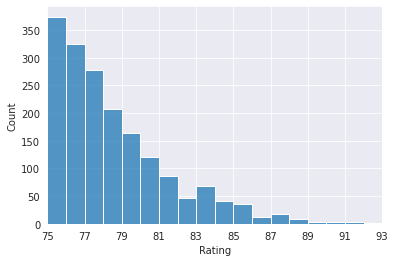

In [7]:
sns.histplot(data=df, x='Rating', bins=range(75, 94))
plt.xlim(75, 93)
plt.xticks(range(75, 95, 2));

Going further, some individual statistic are narrow distributed, while other are widely distributed.
This difference can suggest that some statistics may be more important than other ones.

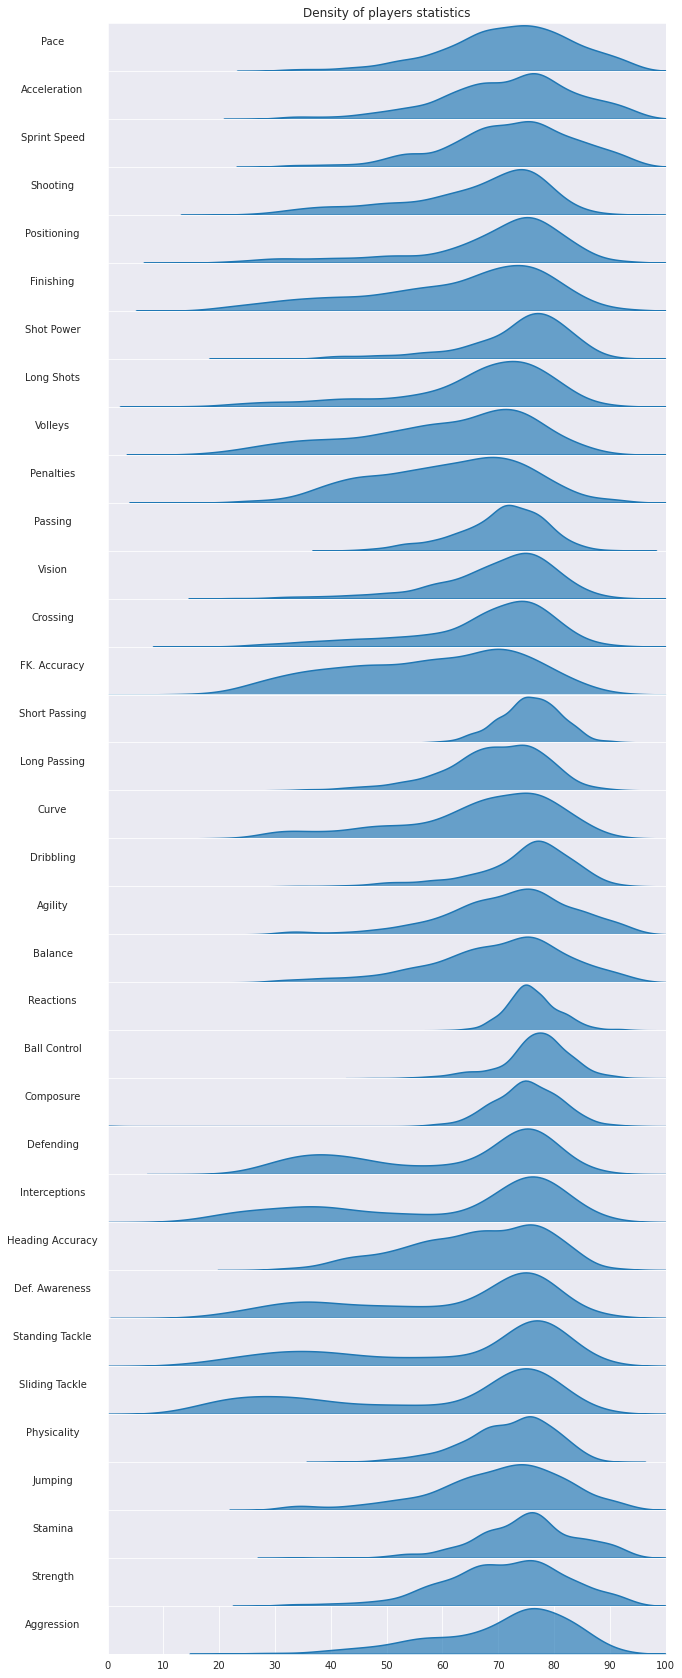

In [8]:
fig, axs = plt.subplots(34, figsize=(10,30))
fig.subplots_adjust(hspace=0.001)
for i, column in enumerate(numeric_columns[3:-1]):
    sns.kdeplot(data=df, x=column, fill=True, alpha=0.65,
                linewidth=1.5, clip=(0, 100), ax=axs[i])
    axs[i].set_ylabel(column, rotation=0)
    axs[i].yaxis.labelpad = 55
    axs[i].set(xlabel=None, xlim=(0, 100), xticks=[], yticks=[])
axs[33].set_xticks(range(0, 110, 10))  # xticks for last subplot
axs[0].set_title('Density of players statistics');  # title on top

We can see, that most fall in 3-4 Skills/WeakFoot starts. Some players have got 5 stars and
almost no one have got 1-star Skills and/or weakFoot. It can suggest that having 5 start can
influence price heavily.

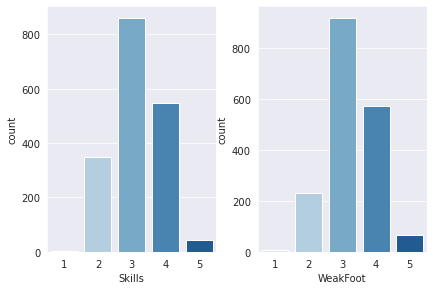

In [9]:
f, axs = plt.subplots(1, 2)

plt.tight_layout()
sns.countplot(data=df, x='Skills', palette='Blues', ax=axs[0])
sns.countplot(data=df, x='WeakFoot', palette='Blues', ax=axs[1]);

I'm removing redundant attributes and splitting data into train and test sets.

In [10]:
df.drop(['Name', 'Club', 'Nation', 'League'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df.values, price, test_size=0.3)

### Data Normalization
There are a few players with missing stats, so I'm going to use KNN-Imputer to fix that.
It is based on KNN algorithm. It checks for the most similar record and fill Nan
with values from it.

In [11]:
imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Some players have got very high price in comparison to others (they may be concluded as outliers), so
I will use MinMaxScaler to fight this issue. It scales each feature individually such that it is in
the given range on the training set, e.g. between zero and one.

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression modeling
I'm going to use a few regressions models to see with suits my data best.

I'll start with standard Ordinary least squares Linear Regression. Since, it is the most
basic model, it will serve as benchmark for other more advanced estimators.

In [13]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
y_predict = clf_linear.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_predict)

Ridge solves a regression model where the loss function is the linear least squares function
and regularization is given by the l2-norm (sum of the squared coefficient values).

In [14]:
clf_ridge = Ridge()
clf_ridge.fit(X_train, y_train)
y_predict = clf_ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_test, y_predict)

Decision Tree Regressor is based on Decision Tree algorithm. It tries to predict output
by learning simple decision rules inferred from the data features.

In [15]:
clf_tree = DecisionTreeRegressor()
clf_tree.fit(X_train, y_train)
y_predict = clf_tree.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_predict)

Support Vector Regression uses the same principle as SVM, but for regression problems.

In [16]:
clf_svr = SVR()
clf_svr.fit(X_train, y_train)
y_predict = clf_svr.predict(X_test)
mae_svr = mean_absolute_error(y_test, y_predict)

Now We are moving to estimators based on ensemble techniques. Idea behind Random Forrest regressor
is to combine multiple decision trees in determining the final
output rather than relying on individual decision trees.

In [17]:
clf_forrest = RandomForestRegressor()
clf_forrest.fit(X_train, y_train)
y_predict = clf_forrest.predict(X_test)
mae_forrest = mean_absolute_error(y_test, y_predict)

Whereas Random Forrest build ensemble of deep independent trees, Gradient Boosting Regressor
build an ensemble of shallow trees in sequence with each tree learning and improving on the previous.

In [18]:
clf_gdb = GradientBoostingRegressor()
clf_gdb.fit(X_train, y_train)
y_predict = clf_gdb.predict(X_test)
mae_gdb = mean_absolute_error(y_test, y_predict)

Comparison of the results of different models shows that GBM performed the best.
I will continue working with it to see if it's' possible to  improve results even more.

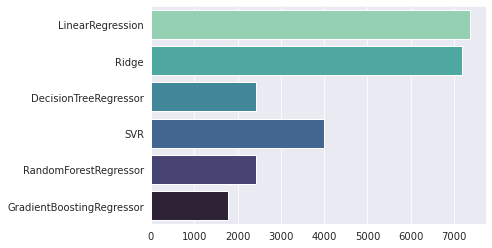

In [19]:
names = ['LinearRegression', 'Ridge', 'DecisionTreeRegressor', 'SVR',
         'RandomForestRegressor', 'GradientBoostingRegressor']
values = [mae_linear, mae_ridge, mae_tree, mae_svr, mae_forrest, mae_gdb]

sns.barplot(x=values, y=names, palette='mako_r');

After searching the best parameters thought RandomizedSearchCV GBR outputs Mean Absolute Error
of about 1000 fifa coins (in game value).

In [20]:
param =  {'n_estimators': [100, 250, 500, 1000, 2000], 'learning_rate': [.001, 0.01, 0.1],
           'max_depth': [1, 2, 4, 8],'subsample': [.5, .75, 1]}
search = RandomizedSearchCV(clf_gdb, param)
search.fit(X_train, y_train)
search.best_params_

{'subsample': 0.5,
 'n_estimators': 1000,
 'max_depth': 2,
 'learning_rate': 0.001}

### Pipelines, saving models
I'm leaving there prediction pipeline with the best estimator.

In [21]:
clf_final = search.best_estimator_
droper = ColumnTransformer([('droper', 'drop', [1, 2, 3, 4])])

steps = [('droper', droper), ('imputer', imputer), ('scaler', scaler), ('clf', clf_final)]
pipeline = Pipeline(steps)
dump(pipeline, open('../models/pipeline.pkl', 'wb'))
